## Dynamical equation

In this notebook, you will implement the forward longitudinal vehicle model. The model accepts throttle inputs and steps through the longitudinal dynamic equations. Once implemented, you will be given a set of inputs that drives over a small road slope to test your model.

The input to the model is a throttle percentage $x_\theta \in [0,1]$ which provides torque to the engine and subsequently accelerates the vehicle for forward motion. 

The dynamic equations consist of many stages to convert throttle inputs to wheel speed (engine -> torque converter -> transmission -> wheel). These stages are bundled together in a single inertia term $J_e$ which is used in the following combined engine dynamic equations.

\begin{align}
    J_e \dot{\omega}_e &= T_e - (GR)(r_{eff} F_{load}) \\ m\ddot{x} &= F_x - F_{load}
\end{align}

Where $T_e$ is the engine torque, $GR$ is the gear ratio, $r_{eff}$ is the effective radius, $m$ is the vehicle mass, $x$ is the vehicle position, $F_x$ is the tire force, and $F_{load}$ is the total load force. 

The engine torque is computed from the throttle input and the engine angular velocity $\omega_e$ using a simplified quadratic model. 

\begin{align}
    T_e = x_{\theta}(a_0 + a_1 \omega_e + a_2 \omega_e^2)
\end{align}

The load forces consist of aerodynamic drag $F_{aero}$, rolling friction $R_x$, and gravitational force $F_g$ from an incline at angle $\alpha$. The aerodynamic drag is a quadratic model and the friction is a linear model.

\begin{align}
    F_{load} &= F_{aero} + R_x + F_g \\
    F_{aero} &= \frac{1}{2} C_a \rho A \dot{x}^2 = c_a \dot{x}^2\\
    R_x &= N(\hat{c}_{r,0} + \hat{c}_{r,1}|\dot{x}| + \hat{c}_{r,2}\dot{x}^2) \approx c_{r,1} \dot{x}\\
    F_g &= mg\sin{\alpha}
\end{align}

Note that the absolute value is ignored for friction since the model is used for only forward motion ($\dot{x} \ge 0$). 
 
The tire force is computed using the engine speed and wheel slip equations.

\begin{align}
    \omega_w &= (GR)\omega_e \\
    s &= \frac{\omega_w r_e - \dot{x}}{\dot{x}}\\
    F_x &= \left\{\begin{array}{lr}
        cs, &  |s| < 1\\
        F_{max}, & \text{otherwise}
        \end{array}\right\} 
\end{align}

Where $\omega_w$ is the wheel angular velocity and $s$ is the slip ratio. 


### longitudinal model
We setup the longitudinal model inside a Python class below. The vehicle begins with an initial velocity of 5 m/s and engine speed of 100 rad/s. All the relevant parameters are defined and like the bicycle model, a sampling time of 10ms is used for numerical integration.

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

class Vehicle():
    def __init__(self):
 
        # ==================================
        #  Parameters
        # ==================================
    
        #Throttle to engine torque
        self.a_0 = 400
        self.a_1 = 0.1
        self.a_2 = -0.0002
        
        # Gear ratio, effective radius, mass + inertia
        self.GR = 0.35
        self.r_e = 0.3
        self.J_e = 10
        self.m = 2000
        self.g = 9.81
        
        # Aerodynamic and friction coefficients
        self.c_a = 1.36
        self.c_r1 = 0.01
        
        # Tire force 
        self.c = 10000
        self.F_max = 10000
        
        # State variables
        self.x = 0
        self.v = 5
        self.a = 0
        self.w_e = 100
        self.w_e_dot = 0
        
        self.sample_time = 0.01
        
    def reset(self):
        # reset state variables
        self.x = 0
        self.v = 5
        self.a = 0
        self.w_e = 100
        self.w_e_dot = 0

## Dynamic Equation

In [8]:
class Vehicle(Vehicle):
    def step(self, throttle, alpha):
        # ==================================
        #  Implement vehicle model here
        # ==================================
         # Throttle to engine torque parameters
        a_0 = self.a_0
        a_1 = self.a_1
        a_2 = self.a_2

        # Gear ratio, effective radius, mass + inertia
        G_R = self.GR
        r_eff = self.r_e
        J_e = self.J_e
        m = self.m
        g = self.g

        # Aerodynamic and friction coefficients
        c_a = self.c_a
        c_r = self.c_r1

        # Tire force parameters
        c_s = self.c
        F_max = self.F_max

        # Unpack state variables
        x_dot = self.v
        x = self.x
        omega_e = self.w_e
        
         # Compute engine torque
        T_e = throttle * (a_0 + a_1 * omega_e + a_2 * omega_e ** 2)

        # Compute load forces
        F_aero = 0.5 * c_a * x_dot ** 2
        R_x = c_r * x_dot
        F_g = m * g * np.sin(alpha)
        F_load = F_aero + R_x + F_g

        # Compute tire force
        s = ( r_eff * G_R * omega_e - x_dot) / x_dot
        if abs(s) < 1:
            F_x = c_s * s
        else:
            F_x = F_max

        # Compute acceleration
        x_dot_dot = (F_x - F_load)/m

        # Update state variables using numerical integration
        x_dot += x_dot_dot * self.sample_time
        x += x_dot * self.sample_time
        omega_e_dot = (T_e - G_R * r_eff * F_load)/J_e
        omega_e += omega_e_dot * self.sample_time

        # Update the state variables of the vehicle
        self.x = x
        self.v = x_dot
        self.a = x_dot_dot
        self.w_e = omega_e
        self.w_e_dot = omega_e_dot


## Flat test

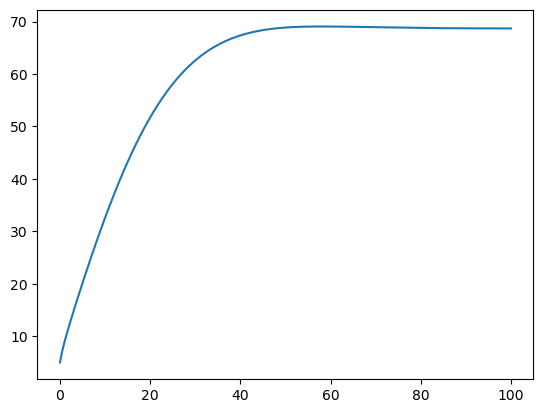

In [9]:
sample_time = 0.01
time_end = 100
model = Vehicle()

t_data = np.arange(0,time_end,sample_time)
v_data = np.zeros_like(t_data)

# throttle percentage between 0 and 1
throttle = 1

# incline angle (in radians)
alpha = 0

for i in range(t_data.shape[0]):
    v_data[i] = model.v
    model.step(throttle, alpha)
    
plt.plot(t_data, v_data)
plt.show()

## slope test

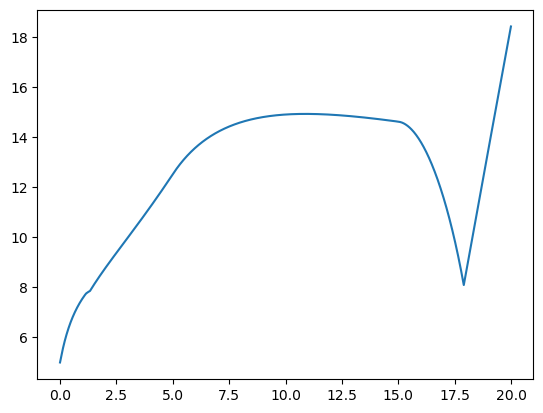

In [16]:
time_end = 20
t_data = np.arange(0,time_end,sample_time)
x_data = np.zeros_like(t_data)
v_data = np.zeros_like(t_data)

model.reset()
throttle = np.zeros_like(t_data)

x1 = np.linspace(0, 5, 500)
x2 = np.linspace(15, 20, 500)
throttle[0:500] = 0.3 / 5 * x1 + 0.2
throttle[1500:] = -0.1 * x2 + 0.5

t1 = np.sqrt(60^2 + 3^2) 
t2 = np.sqrt(90^2 + 9^2)
for i in range(t_data.shape[0]):
    x_data[i] = model.x
    v_data[i] = model.v

    if x_data[i] < t1:
        alpha = np.arctan(1/20)
    elif t1 <= x_data[i] < t2:
        alpha = np.arctan(1/10)
    else:
        alpha = 0
    model.step(throttle[i], alpha)
    
plt.plot(t_data, v_data)
plt.show()